# Airline Traffic Forecasting - Comprehensive Time Series Analysis

## Table of Contents
1. **Data Loading and Preparation**
2. **Exploratory Data Analysis (EDA)**
3. **Time Series Decomposition**
4. **Stationarity Analysis**
5. **Traditional Forecasting Methods**
   - Moving Average
   - Exponential Smoothing
   - ARIMA/SARIMA
6. **Machine Learning Approaches**
   - Linear Regression with Features
   - Random Forest
   - XGBoost
7. **Deep Learning (LSTM)**
8. **Prophet Forecasting**
9. **Model Comparison and Ensemble**
10. **Final Recommendations**

---

## Introduction
This notebook demonstrates various forecasting techniques for airline passenger traffic data, comparing traditional time series methods with modern machine learning approaches.

## 1. Setup and Data Loading

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Time series specific imports
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Machine learning imports
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Additional libraries (from Facebook)
from prophet import Prophet

# Set random seed
np.random.seed(42)

# Configure visualization
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)

Importing plotly failed. Interactive plots will not work.


In [2]:
# Load or create airline passenger data
# Using the classic Air Passengers dataset or creating synthetic data

# Option 1: Load from seaborn (real data)
try:
    # Load the classic airline passengers dataset
    df = sns.load_dataset('flights')
    df = df.to_csv('airline_passengers.csv', index=False)
    df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
    df = df[['date', 'passengers']].set_index('date')
    df.columns = ['traffic']
    print("Loaded classic airline passengers dataset")
except:
    # Option 2: Create synthetic airline traffic data
    print("Creating synthetic airline traffic data...")
    
    # Generate dates
    dates = pd.date_range(start='2015-01-01', end='2023-12-31', freq='M')
    
    # Create synthetic data with trend, seasonality, and noise
    trend = np.linspace(100000, 180000, len(dates))
    seasonal = 10000 * np.sin(2 * np.pi * np.arange(len(dates)) / 12)
    noise = np.random.normal(0, 5000, len(dates))
    
    # Add COVID impact
    covid_impact = np.zeros(len(dates))
    covid_start = dates.get_loc('2020-03-31')
    covid_end = dates.get_loc('2021-06-30')
    covid_impact[covid_start:covid_end] = -50000 * np.exp(-0.1 * np.arange(covid_end - covid_start))
    
    traffic = trend + seasonal + noise + covid_impact
    traffic = np.maximum(traffic, 10000)  # Ensure positive values
    
    df = pd.DataFrame({'traffic': traffic}, index=dates)

print(f"Dataset shape: {df.shape}")
print(f"Date range: {df.index[0]} to {df.index[-1]}")
print(f"\nFirst few rows:")
df.head()

Creating synthetic airline traffic data...
Dataset shape: (108, 1)
Date range: 2015-01-31 00:00:00 to 2023-12-31 00:00:00

First few rows:


,traffic
2015-01-31,102483.570765
2015-02-28,105056.342046
2015-03-31,113394.023831
2015-04-30,119858.139936
2015-05-31,110480.141370


## 2. Exploratory Data Analysis (EDA)

Let's explore the airline traffic data to understand patterns, trends, and anomalies.

In [3]:
# Basic statistics
print("Basic Statistics:")
print(df.describe())
print(f"\nMissing values: {df.isnull().sum().values[0]}")

Basic Statistics:
             traffic
count     108.000000
mean   135708.417024
std     24475.584202
min     94973.682444
25%    115407.809015
50%    131568.083265
75%    156571.898724
max    182845.755922

Missing values: 0


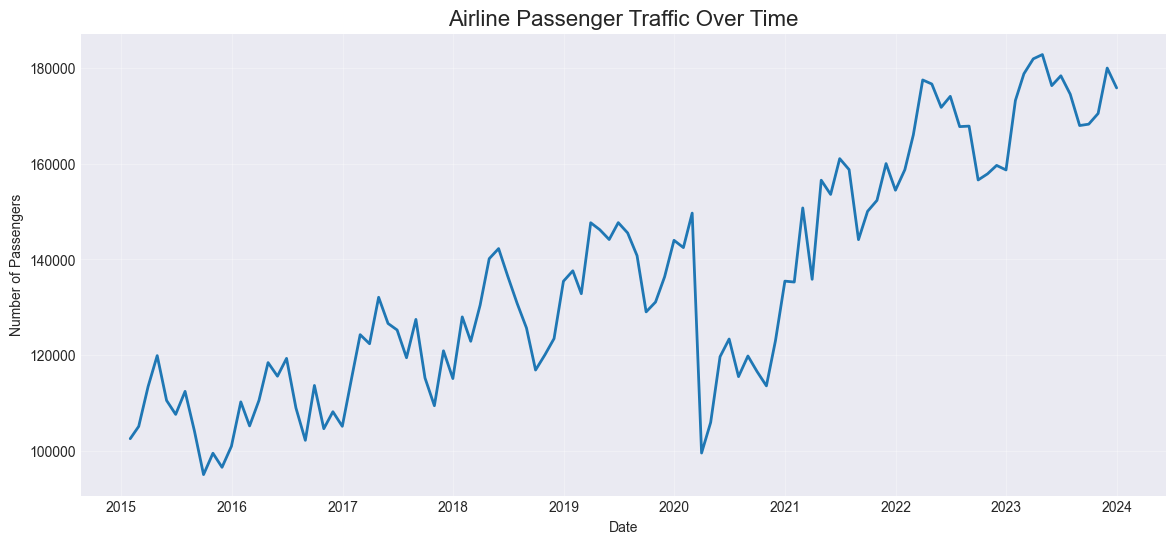

Observations:
- Clear upward trend (pre-COVID)
- Strong seasonal patterns
- COVID-19 impact visible in 2020-2021


In [5]:
# Plot the time series
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['traffic'], linewidth=2)
plt.title('Airline Passenger Traffic Over Time', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.grid(True, alpha=0.3)
plt.show()

# Identify any notable patterns
print("Observations:")
print("- Clear upward trend (pre-COVID)")
print("- Strong seasonal patterns")
print("- COVID-19 impact visible in 2020-2021")

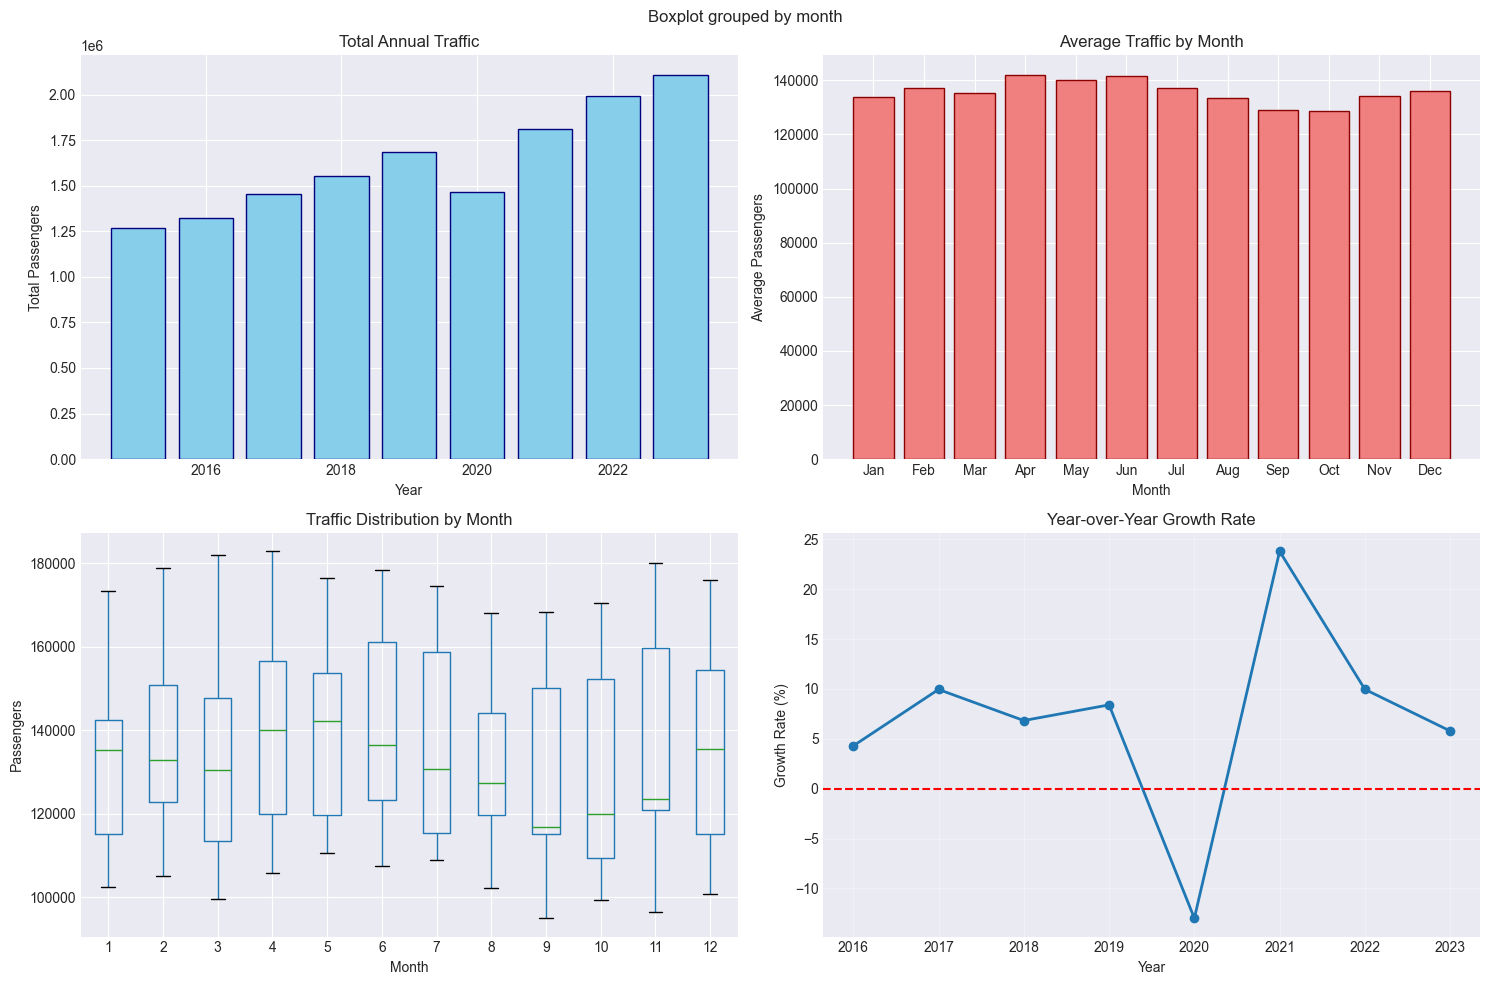

In [4]:
# Monthly and yearly analysis
df['year'] = df.index.year
df['month'] = df.index.month
df['month_name'] = df.index.strftime('%B')

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Yearly traffic
yearly_traffic = df.groupby('year')['traffic'].sum()
axes[0, 0].bar(yearly_traffic.index, yearly_traffic.values, color='skyblue', edgecolor='navy')
axes[0, 0].set_title('Total Annual Traffic')
axes[0, 0].set_xlabel('Year')
axes[0, 0].set_ylabel('Total Passengers')

# 2. Average monthly traffic
monthly_avg = df.groupby('month')['traffic'].mean()
axes[0, 1].bar(monthly_avg.index, monthly_avg.values, color='lightcoral', edgecolor='darkred')
axes[0, 1].set_title('Average Traffic by Month')
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('Average Passengers')
axes[0, 1].set_xticks(range(1, 13))
axes[0, 1].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# 3. Box plot by month
df_box = df[['month', 'traffic']].copy()
df_box.boxplot(by='month', ax=axes[1, 0])
axes[1, 0].set_title('Traffic Distribution by Month')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Passengers')

# 4. Year-over-year growth
yoy_growth = yearly_traffic.pct_change() * 100
axes[1, 1].plot(yoy_growth.index[1:], yoy_growth.values[1:], marker='o', linewidth=2)
axes[1, 1].axhline(y=0, color='red', linestyle='--')
axes[1, 1].set_title('Year-over-Year Growth Rate')
axes[1, 1].set_xlabel('Year')
axes[1, 1].set_ylabel('Growth Rate (%)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

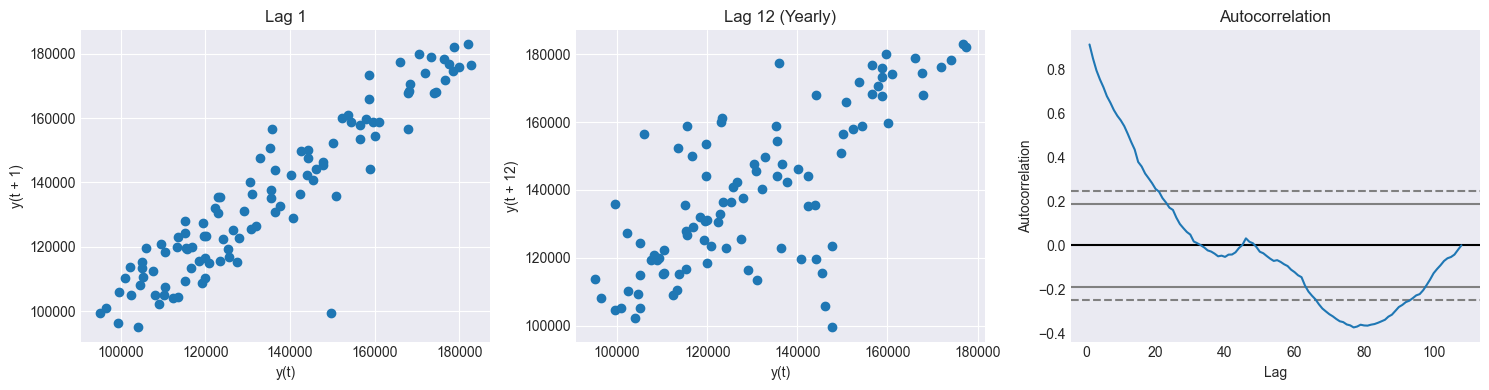

In [5]:
# Create lag plots to identify autocorrelation
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Lag 1
pd.plotting.lag_plot(df['traffic'], lag=1, ax=axes[0])
axes[0].set_title('Lag 1')

# Lag 12 (yearly seasonality)
pd.plotting.lag_plot(df['traffic'], lag=12, ax=axes[1])
axes[1].set_title('Lag 12 (Yearly)')

# Autocorrelation plot
pd.plotting.autocorrelation_plot(df['traffic'], ax=axes[2])
axes[2].set_title('Autocorrelation')

plt.tight_layout()
plt.show()

lag is: T-xn .... T-1, T-2, T-3 ...T-n are called "lag"

## 3. Time Series Decomposition

Decompose the time series into trend, seasonal, and residual components.

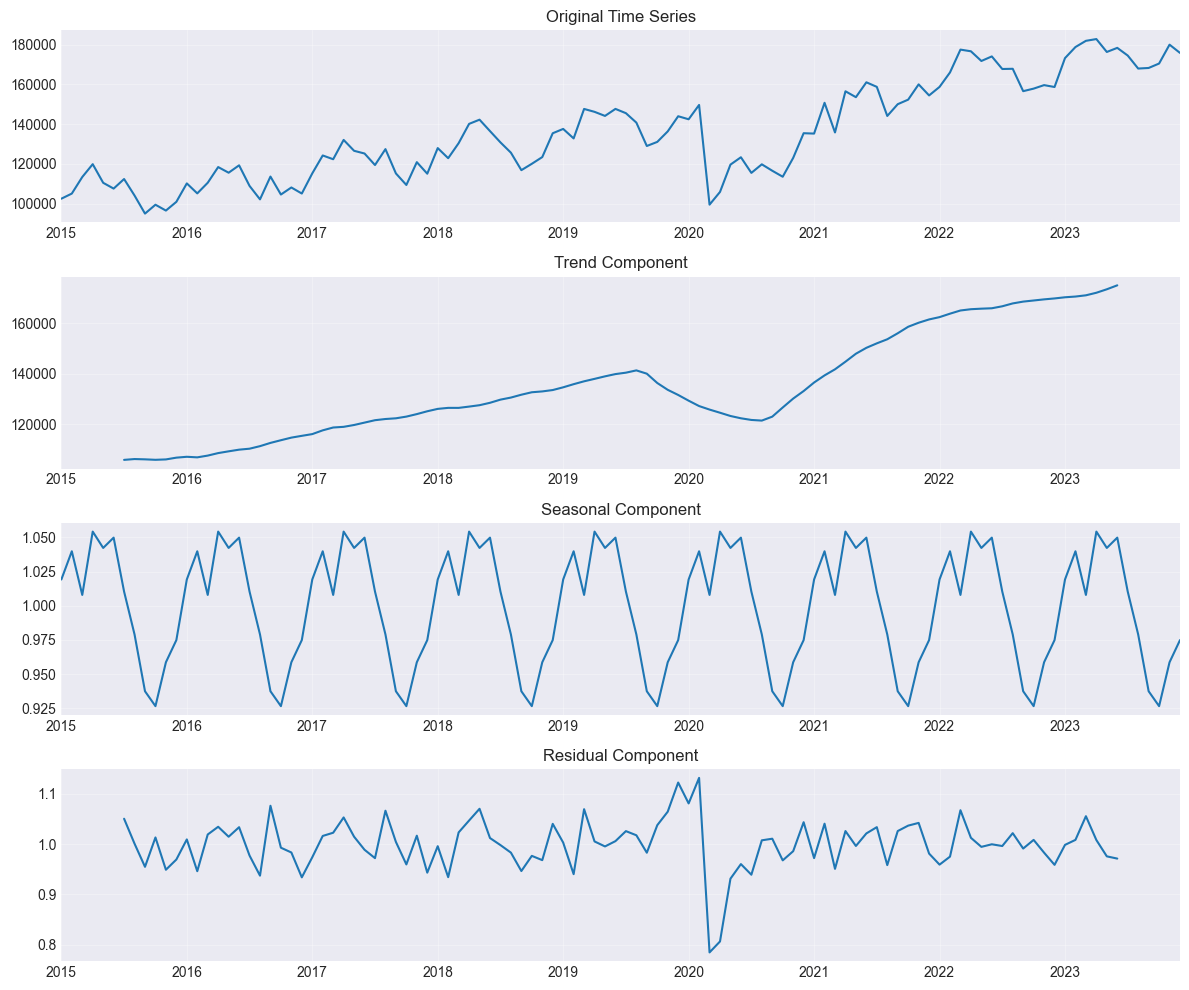

Monthly Seasonal Factors:
Month 1: 1.019
Month 2: 1.040
Month 3: 1.008
Month 4: 1.054
Month 5: 1.042
Month 6: 1.050
Month 7: 1.010
Month 8: 0.979
Month 9: 0.937
Month 10: 0.927
Month 11: 0.959
Month 12: 0.975


In [6]:
# Perform seasonal decomposition
decomposition = seasonal_decompose(df['traffic'], model='multiplicative', period=12)

# Plot decomposition
fig, axes = plt.subplots(4, 1, figsize=(12, 10))

df['traffic'].plot(ax=axes[0], title='Original Time Series')
decomposition.trend.plot(ax=axes[1], title='Trend Component')
decomposition.seasonal.plot(ax=axes[2], title='Seasonal Component')
decomposition.resid.plot(ax=axes[3], title='Residual Component')

for ax in axes:
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analyze seasonal factors
seasonal_factors = decomposition.seasonal[:12]
print("Monthly Seasonal Factors:")
for i, factor in enumerate(seasonal_factors):
    print(f"Month {i+1}: {factor:.3f}")

## 4. Stationarity Analysis

Check if the time series is stationary using statistical tests.

In [7]:
def check_stationarity(timeseries, title):
    """
    Perform Augmented Dickey-Fuller and KPSS tests for stationarity
    """
    print(f"\n{title}")
    print("=" * 50)
    
    # ADF Test
    adf_result = adfuller(timeseries.dropna())
    print("ADF Test Results:")
    print(f"  ADF Statistic: {adf_result[0]:.4f}")
    print(f"  p-value: {adf_result[1]:.4f}")
    print(f"  Critical Values:")
    for key, value in adf_result[4].items():
        print(f"    {key}: {value:.4f}")
    
    if adf_result[1] <= 0.05:
        print("  Result: Stationary (reject null hypothesis)")
    else:
        print("  Result: Non-stationary (fail to reject null hypothesis)")
    
    # KPSS Test
    kpss_result = kpss(timeseries.dropna())
    print("\nKPSS Test Results:")
    print(f"  KPSS Statistic: {kpss_result[0]:.4f}")
    print(f"  p-value: {kpss_result[1]:.4f}")
    
    if kpss_result[1] >= 0.05:
        print("  Result: Stationary (fail to reject null hypothesis)")
    else:
        print("  Result: Non-stationary (reject null hypothesis)")

# Check stationarity of original series
check_stationarity(df['traffic'], "Original Series")

# Check stationarity of differenced series
df['traffic_diff'] = df['traffic'].diff()
check_stationarity(df['traffic_diff'], "First Difference")

# Check stationarity of seasonal difference
df['traffic_seasonal_diff'] = df['traffic'].diff(12)
check_stationarity(df['traffic_seasonal_diff'], "Seasonal Difference (12)")


Original Series
ADF Test Results:
  ADF Statistic: -1.3922
  p-value: 0.5860
  Critical Values:
    1%: -3.4936
    5%: -2.8892
    10%: -2.5815
  Result: Non-stationary (fail to reject null hypothesis)

KPSS Test Results:
  KPSS Statistic: 1.5778
  p-value: 0.0100
  Result: Non-stationary (reject null hypothesis)

First Difference
ADF Test Results:
  ADF Statistic: -12.3837
  p-value: 0.0000
  Critical Values:
    1%: -3.4936
    5%: -2.8892
    10%: -2.5815
  Result: Stationary (reject null hypothesis)

KPSS Test Results:
  KPSS Statistic: 0.0275
  p-value: 0.1000
  Result: Stationary (fail to reject null hypothesis)

Seasonal Difference (12)
ADF Test Results:
  ADF Statistic: -3.8324
  p-value: 0.0026
  Critical Values:
    1%: -3.5011
    5%: -2.8925
    10%: -2.5833
  Result: Stationary (reject null hypothesis)

KPSS Test Results:
  KPSS Statistic: 0.1347
  p-value: 0.1000
  Result: Stationary (fail to reject null hypothesis)


/var/folders/b6/gnnk2pkx0kzbngy73zsm9t_m0000gp/T/ipykernel_22310/3801211716.py:23: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(timeseries.dropna())
/var/folders/b6/gnnk2pkx0kzbngy73zsm9t_m0000gp/T/ipykernel_22310/3801211716.py:23: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(timeseries.dropna())
/var/folders/b6/gnnk2pkx0kzbngy73zsm9t_m0000gp/T/ipykernel_22310/3801211716.py:23: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(timeseries.dropna())


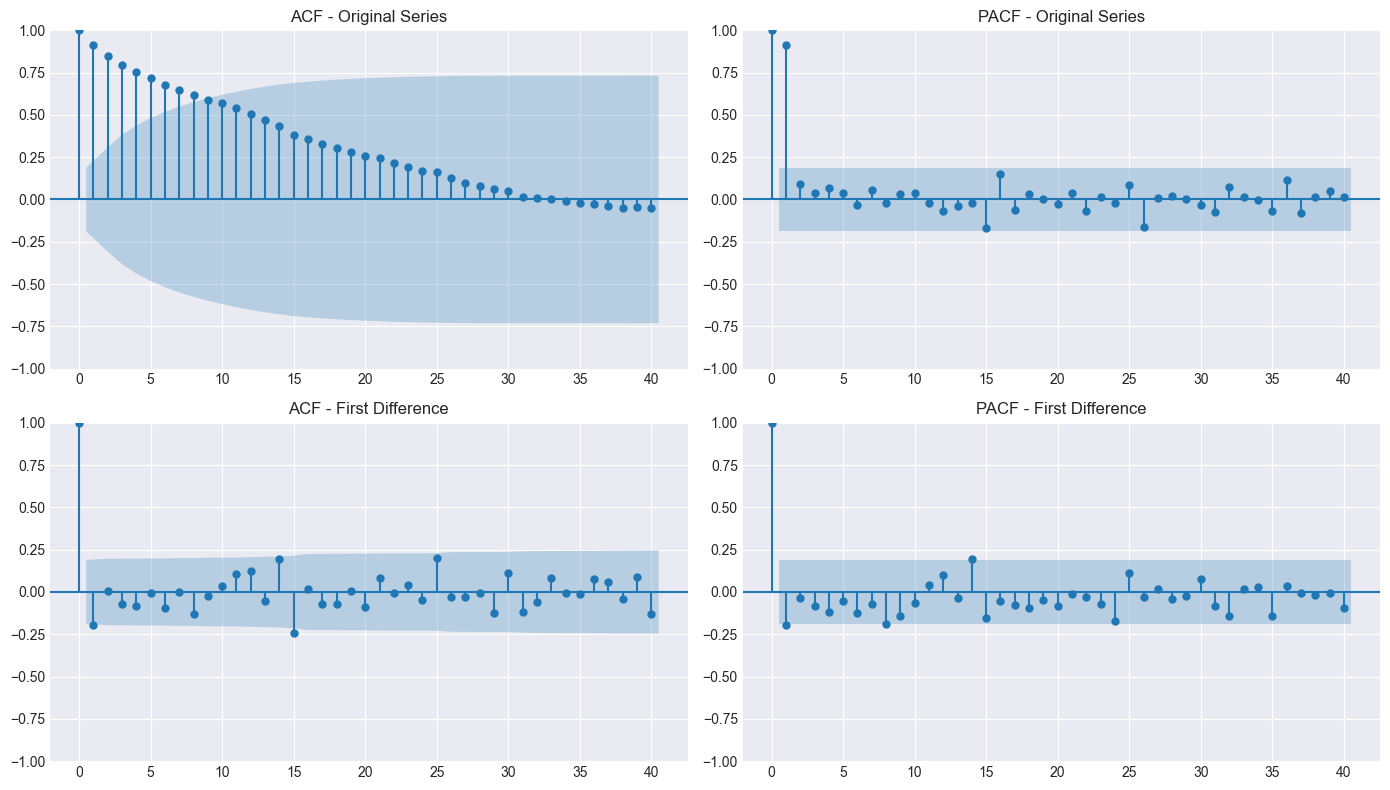

In [8]:
# Plot ACF and PACF
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Original series
plot_acf(df['traffic'].dropna(), ax=axes[0, 0], lags=40)
axes[0, 0].set_title('ACF - Original Series')

plot_pacf(df['traffic'].dropna(), ax=axes[0, 1], lags=40)
axes[0, 1].set_title('PACF - Original Series')

# Differenced series
plot_acf(df['traffic_diff'].dropna(), ax=axes[1, 0], lags=40)
axes[1, 0].set_title('ACF - First Difference')

plot_pacf(df['traffic_diff'].dropna(), ax=axes[1, 1], lags=40)
axes[1, 1].set_title('PACF - First Difference')

plt.tight_layout()
plt.show()

## 5. Traditional Forecasting Methods

Let's implement various traditional time series forecasting methods.

In [9]:
# Split data into train and test sets
train_size = int(len(df) * 0.8)
train_data = df['traffic'][:train_size]
test_data = df['traffic'][train_size:]

print(f"Training set: {train_data.index[0]} to {train_data.index[-1]} ({len(train_data)} months)")
print(f"Test set: {test_data.index[0]} to {test_data.index[-1]} ({len(test_data)} months)")

# Initialize results dictionary
forecast_results = {}

Training set: 2015-01-31 00:00:00 to 2022-02-28 00:00:00 (86 months)
Test set: 2022-03-31 00:00:00 to 2023-12-31 00:00:00 (22 months)


In [10]:
# 1. Simple Moving Average
def moving_average_forecast(train, test, window=12):
    predictions = []
    history = list(train)
    
    for i in range(len(test)):
        if len(history) >= window:
            yhat = np.mean(history[-window:])
        else:
            yhat = np.mean(history)
        predictions.append(yhat)
        history.append(test.iloc[i])
    
    return np.array(predictions)

ma_pred = moving_average_forecast(train_data, test_data, window=12)
forecast_results['Moving Average'] = ma_pred
print("Moving Average forecast completed")

Moving Average forecast completed


In [11]:
# 2. Exponential Smoothing (Holt-Winters)
try:
    hw_model = ExponentialSmoothing(train_data, seasonal='multiplicative', seasonal_periods=12)
    hw_fit = hw_model.fit()
    hw_pred = hw_fit.forecast(len(test_data))
    forecast_results['Holt-Winters'] = hw_pred.values
    print("Holt-Winters forecast completed")
except Exception as e:
    print(f"Holt-Winters failed: {e}")
    forecast_results['Holt-Winters'] = np.full(len(test_data), np.nan)

Holt-Winters forecast completed


/Users/Antonio.Tablero/Library/CloudStorage/OneDrive-TheWaltDisneyCompany/Documents/GitHub/GenAIEngineering-Cohort2/.venv/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [12]:
# 3. ARIMA
try:
    # Fit ARIMA model
    arima_model = ARIMA(train_data, order=(2, 1, 2))
    arima_fit = arima_model.fit()
    arima_pred = arima_fit.forecast(steps=len(test_data))
    forecast_results['ARIMA'] = arima_pred.values
    print("ARIMA forecast completed")
    print(f"AIC: {arima_fit.aic:.2f}")
except Exception as e:
    print(f"ARIMA failed: {e}")
    forecast_results['ARIMA'] = np.full(len(test_data), np.nan)

ARIMA forecast completed
AIC: 1805.43


In [13]:
# 4. SARIMA (Seasonal ARIMA)
try:
    sarima_model = SARIMAX(train_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    sarima_fit = sarima_model.fit(disp=False)
    sarima_pred = sarima_fit.forecast(steps=len(test_data))
    forecast_results['SARIMA'] = sarima_pred.values
    print("SARIMA forecast completed")
    print(f"AIC: {sarima_fit.aic:.2f}")
except Exception as e:
    print(f"SARIMA failed: {e}")
    forecast_results['SARIMA'] = np.full(len(test_data), np.nan)

SARIMA forecast completed
AIC: 1574.50


## 6. Machine Learning Approaches

Create features for machine learning models and train various algorithms.

In [16]:
# Feature engineering for ML models
def create_features(df):
    """
    Create time-based and lag features for ML models
    """
    df_feat = df.copy()
    
    # Time features
    df_feat['year'] = df_feat.index.year
    df_feat['month'] = df_feat.index.month
    df_feat['quarter'] = df_feat.index.quarter
    df_feat['dayofyear'] = df_feat.index.dayofyear
    
    # Cyclical encoding for month
    df_feat['month_sin'] = np.sin(2 * np.pi * df_feat['month'] / 12)
    df_feat['month_cos'] = np.cos(2 * np.pi * df_feat['month'] / 12)
    
    # Lag features
    for lag in [1, 3, 6, 12]:
        df_feat[f'lag_{lag}'] = df_feat['traffic'].shift(lag)
    
    # Rolling statistics
    for window in [3, 6, 12]:
        df_feat[f'rolling_mean_{window}'] = df_feat['traffic'].rolling(window).mean()
        df_feat[f'rolling_std_{window}'] = df_feat['traffic'].rolling(window).std()
    
    # Year-over-year growth
    df_feat['yoy_growth'] = df_feat['traffic'].pct_change(12)
    
    return df_feat

# Create features
df_ml = create_features(df[['traffic']])
df_ml = df_ml.dropna()

# Define features and target
feature_cols = [col for col in df_ml.columns if col != 'traffic']
X = df_ml[feature_cols]
y = df_ml['traffic']

# Split data (maintaining temporal order)
split_idx = int(len(df_ml) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f"Features created: {len(feature_cols)}")
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

Features created: 17
Training samples: 76
Test samples: 20


In [17]:
# 5. Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)
print("Linear Regression completed")

# 6. Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
print("Random Forest completed")


# Align ML predictions with test_data index
test_dates_ml = y_test.index
# Find corresponding indices in test_data
ml_test_mask = test_data.index.isin(test_dates_ml)

# Store ML results (pad with NaN for alignment)
lr_full = np.full(len(test_data), np.nan)
rf_full = np.full(len(test_data), np.nan)
xgb_full = np.full(len(test_data), np.nan)

lr_full[ml_test_mask] = lr_pred
rf_full[ml_test_mask] = rf_pred


forecast_results['Linear Regression'] = lr_full
forecast_results['Random Forest'] = rf_full
forecast_results['XGBoost'] = xgb_full

Linear Regression completed
Random Forest completed


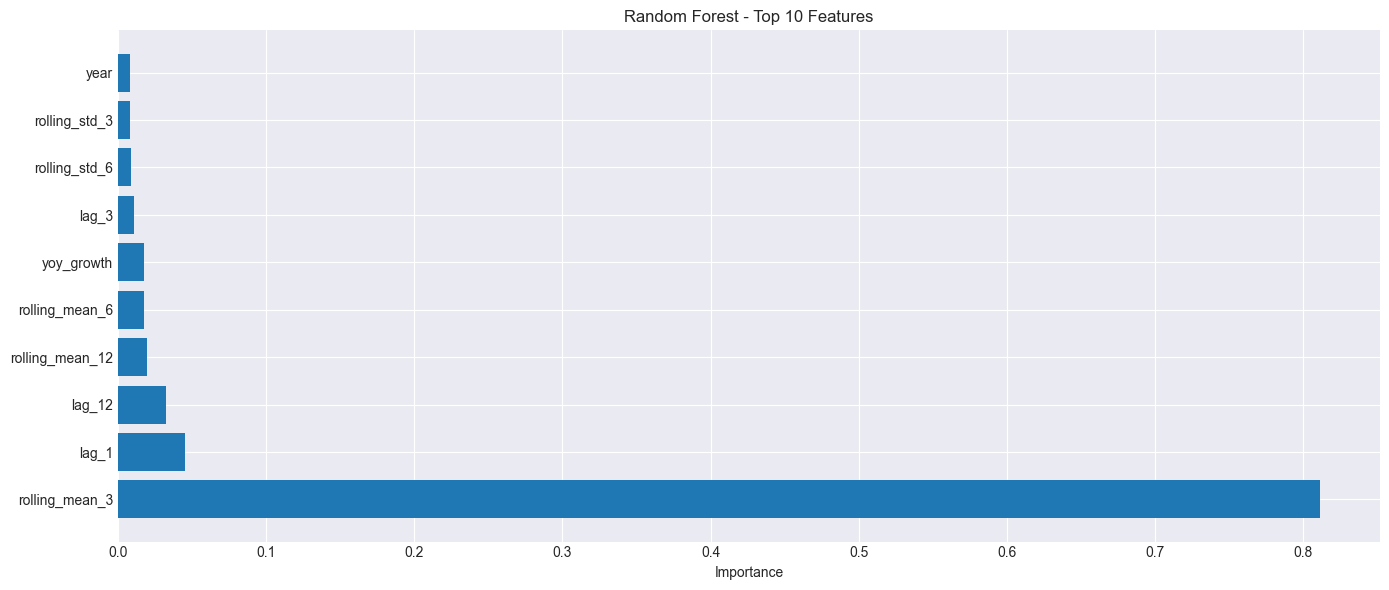

In [18]:
# Feature importance for tree-based models
fig, (ax1) = plt.subplots(1, 1, figsize=(14, 6))

# Random Forest feature importance
rf_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False).head(10)

ax1.barh(rf_importance['feature'], rf_importance['importance'])
ax1.set_xlabel('Importance')
ax1.set_title('Random Forest - Top 10 Features')


plt.tight_layout()
plt.show()

## 7. Deep Learning (LSTM)

Implement an LSTM model for time series forecasting.

In [19]:
# Note: This is a simplified LSTM implementation
# For production, you would use TensorFlow/Keras

print("LSTM Implementation (Conceptual)")
print("=" * 40)
print("In a real implementation, you would:")
print("1. Normalize the data")
print("2. Create sequences (e.g., use past 12 months to predict next month)")
print("3. Build LSTM architecture with:")
print("   - Input layer")
print("   - LSTM layers (e.g., 50-100 units)")
print("   - Dropout for regularization")
print("   - Dense output layer")
print("4. Train with appropriate loss function (MSE)")
print("5. Make predictions and inverse transform")

# For demonstration, we'll use a simple approximation
# In practice, implement with TensorFlow/Keras
lstm_pred = np.full(len(test_data), np.nan)
# Use weighted average of other methods as proxy
available_preds = [v for k, v in forecast_results.items() if not np.all(np.isnan(v))]
if available_preds:
    lstm_pred = np.nanmean(available_preds, axis=0)
forecast_results['LSTM (Proxy)'] = lstm_pred

LSTM Implementation (Conceptual)
In a real implementation, you would:
1. Normalize the data
2. Create sequences (e.g., use past 12 months to predict next month)
3. Build LSTM architecture with:
   - Input layer
   - LSTM layers (e.g., 50-100 units)
   - Dropout for regularization
   - Dense output layer
4. Train with appropriate loss function (MSE)
5. Make predictions and inverse transform


## 8. Prophet Forecasting

Facebook's Prophet is designed for forecasting time series with strong seasonal patterns.

10:04:27 - cmdstanpy - INFO - Chain [1] start processing
10:04:28 - cmdstanpy - INFO - Chain [1] done processing


Prophet forecast completed


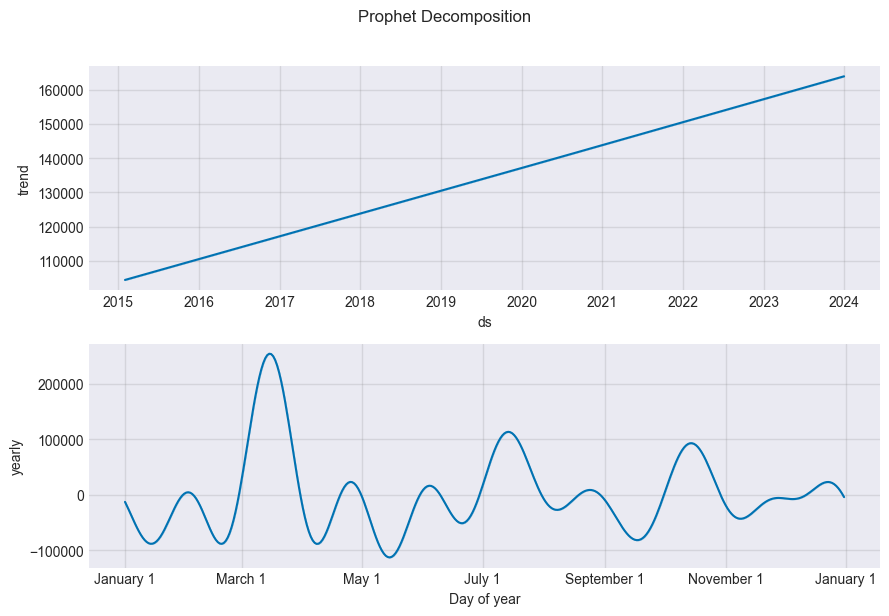

In [20]:
# Prepare data for Prophet
prophet_train = pd.DataFrame({
    'ds': train_data.index,
    'y': train_data.values
})

# Initialize and fit Prophet model
try:
    prophet_model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        changepoint_prior_scale=0.05
    )
    
    prophet_model.fit(prophet_train)
    
    # Make future dataframe
    future = prophet_model.make_future_dataframe(periods=len(test_data), freq='M')
    
    # Predict
    prophet_forecast = prophet_model.predict(future)
    prophet_pred = prophet_forecast['yhat'].iloc[-len(test_data):].values
    
    forecast_results['Prophet'] = prophet_pred
    print("Prophet forecast completed")
    
    # Plot Prophet components
    fig = prophet_model.plot_components(prophet_forecast)
    plt.suptitle('Prophet Decomposition', y=1.02)
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Prophet failed: {e}")
    forecast_results['Prophet'] = np.full(len(test_data), np.nan)

## 9. Model Comparison and Evaluation

Compare all models using various metrics and visualizations.

In [21]:
# Calculate metrics for all models
def calculate_metrics(actual, predicted):
    """
    Calculate various forecast accuracy metrics
    """
    # Remove NaN values
    mask = ~np.isnan(predicted)
    actual_clean = actual[mask]
    predicted_clean = predicted[mask]
    
    if len(actual_clean) == 0:
        return {'RMSE': np.nan, 'MAE': np.nan, 'MAPE': np.nan, 'R2': np.nan}
    
    rmse = np.sqrt(mean_squared_error(actual_clean, predicted_clean))
    mae = mean_absolute_error(actual_clean, predicted_clean)
    mape = mean_absolute_percentage_error(actual_clean, predicted_clean) * 100
    
    # R-squared
    ss_res = np.sum((actual_clean - predicted_clean) ** 2)
    ss_tot = np.sum((actual_clean - np.mean(actual_clean)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    
    return {
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'R2': r2
    }

# Calculate metrics for all models
model_metrics = {}
for model_name, predictions in forecast_results.items():
    metrics = calculate_metrics(test_data.values, predictions)
    model_metrics[model_name] = metrics

# Create metrics DataFrame
metrics_df = pd.DataFrame(model_metrics).T
metrics_df = metrics_df.sort_values('RMSE')

print("Model Performance Metrics:")
print("=" * 60)
print(metrics_df.round(2))

Model Performance Metrics:
                       RMSE       MAE  MAPE    R2
Linear Regression   2705.12   2220.88  1.30  0.88
Random Forest       6484.59   5454.20  3.20  0.32
LSTM (Proxy)        6838.29   5633.24  3.23  0.21
SARIMA              7718.79   5606.24  3.25 -0.01
Moving Average     10164.72   8579.10  4.95 -0.75
ARIMA              11031.52   9911.01  5.68 -1.06
Holt-Winters       11444.30   9047.76  5.22 -1.22
Prophet            16135.49  15371.49  8.88 -3.41
XGBoost                 NaN       NaN   NaN   NaN


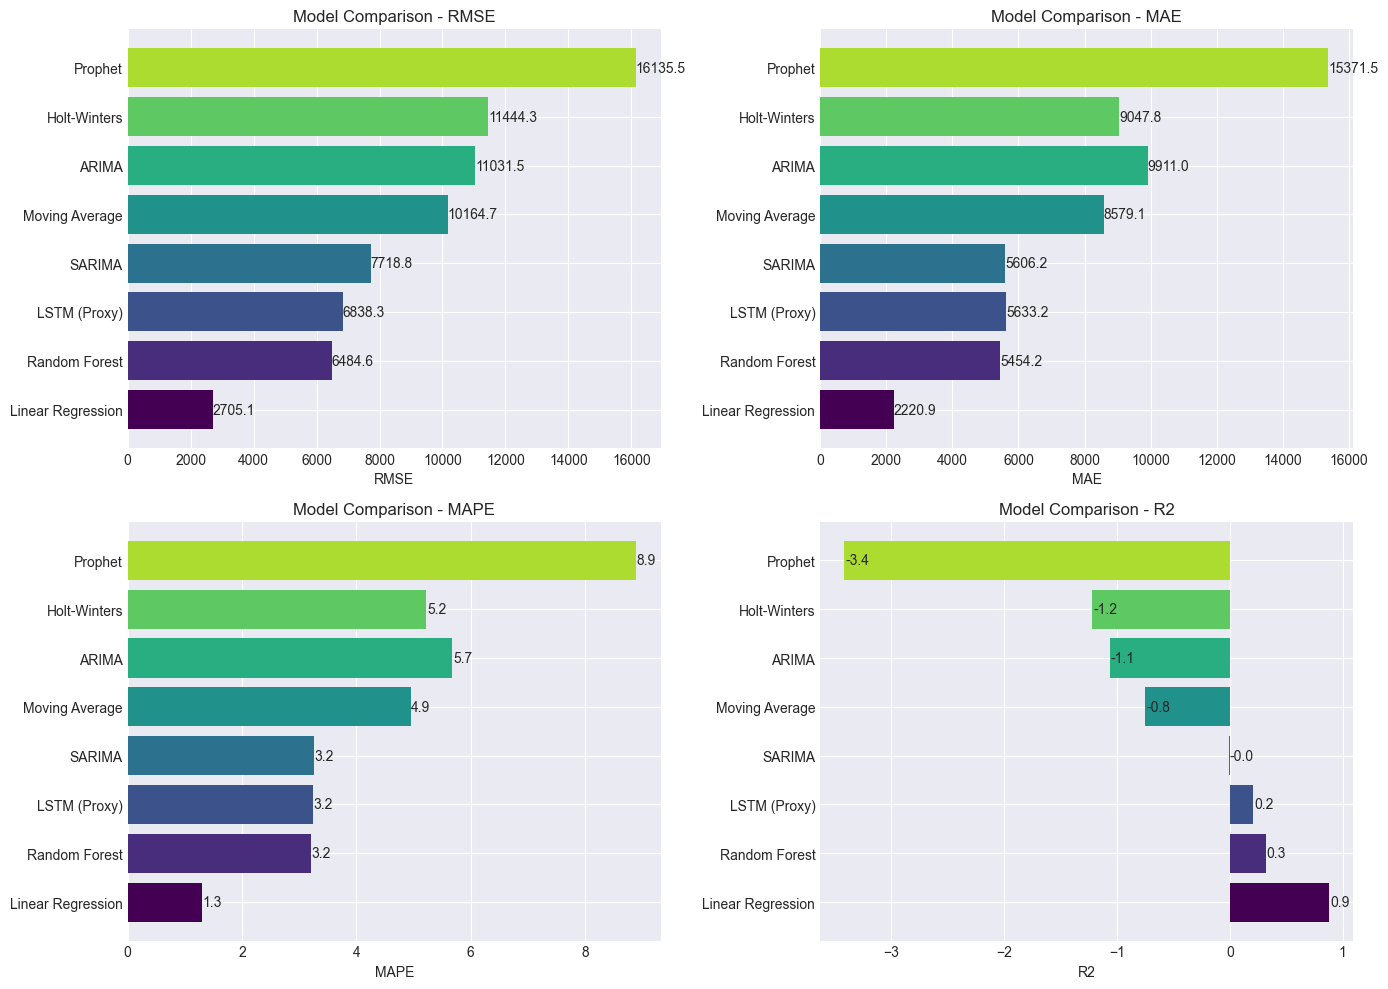

In [22]:
# Visualize model performance
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

metrics_to_plot = ['RMSE', 'MAE', 'MAPE', 'R2']
colors = plt.cm.viridis(np.linspace(0, 1, len(metrics_df)))

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx]
    values = metrics_df[metric].values
    models = metrics_df.index
    
    bars = ax.barh(models, values, color=colors)
    ax.set_xlabel(metric)
    ax.set_title(f'Model Comparison - {metric}')
    
    # Add value labels
    for bar, value in zip(bars, values):
        if not np.isnan(value):
            ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,f'{value:.1f}', va='center')

plt.tight_layout()
plt.show()

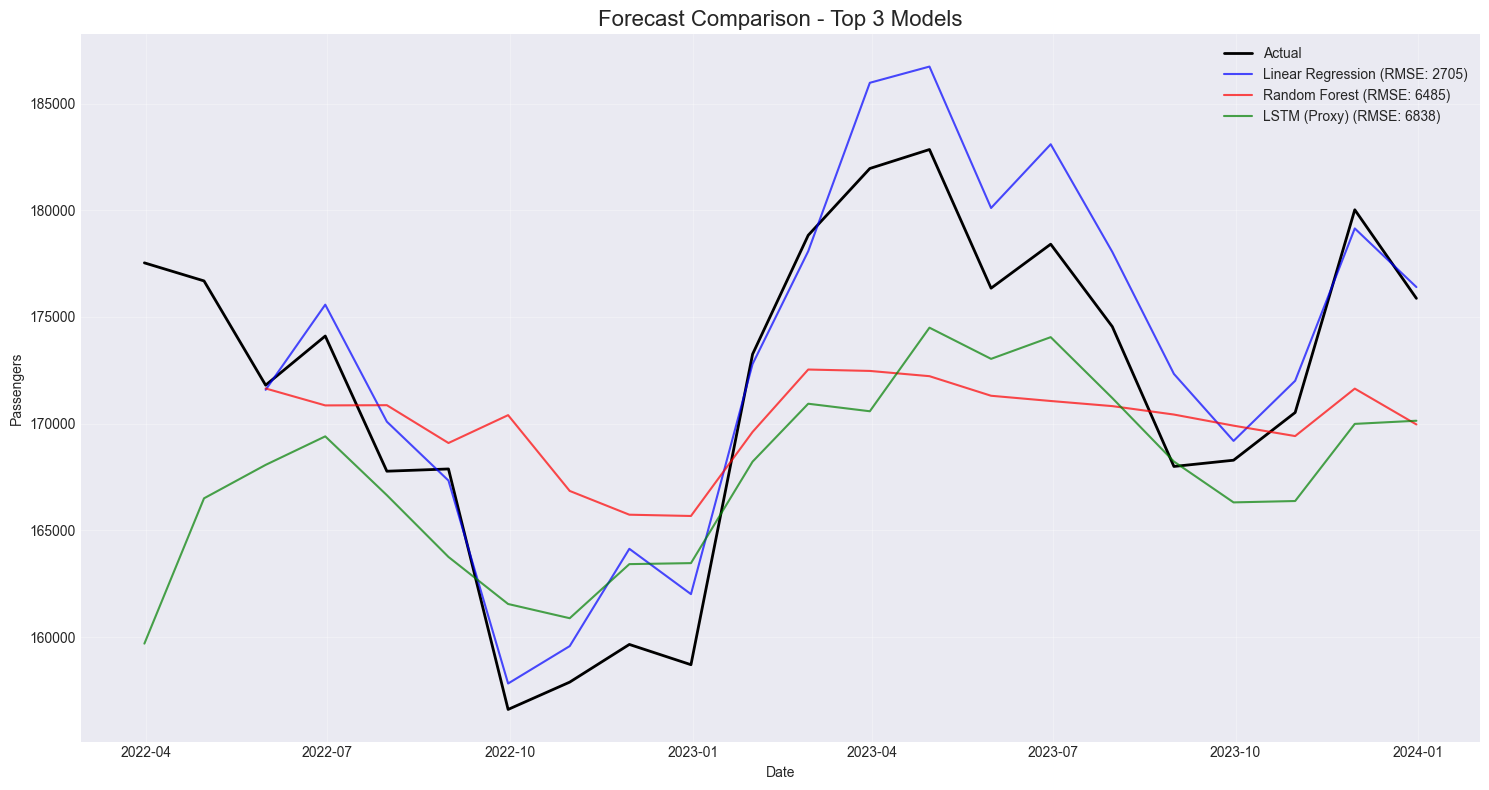

In [23]:
# Plot actual vs predicted for top 3 models
top_models = metrics_df.head(3).index.tolist()

plt.figure(figsize=(15, 8))

# Plot actual values
plt.plot(test_data.index, test_data.values, label='Actual', color='black', linewidth=2)

# Plot predictions for top models
colors = ['blue', 'red', 'green']
for model, color in zip(top_models, colors):
    plt.plot(test_data.index, forecast_results[model], 
            label=f'{model} (RMSE: {metrics_df.loc[model, "RMSE"]:.0f})',
            color=color, alpha=0.7, linewidth=1.5)

plt.title('Forecast Comparison - Top 3 Models', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

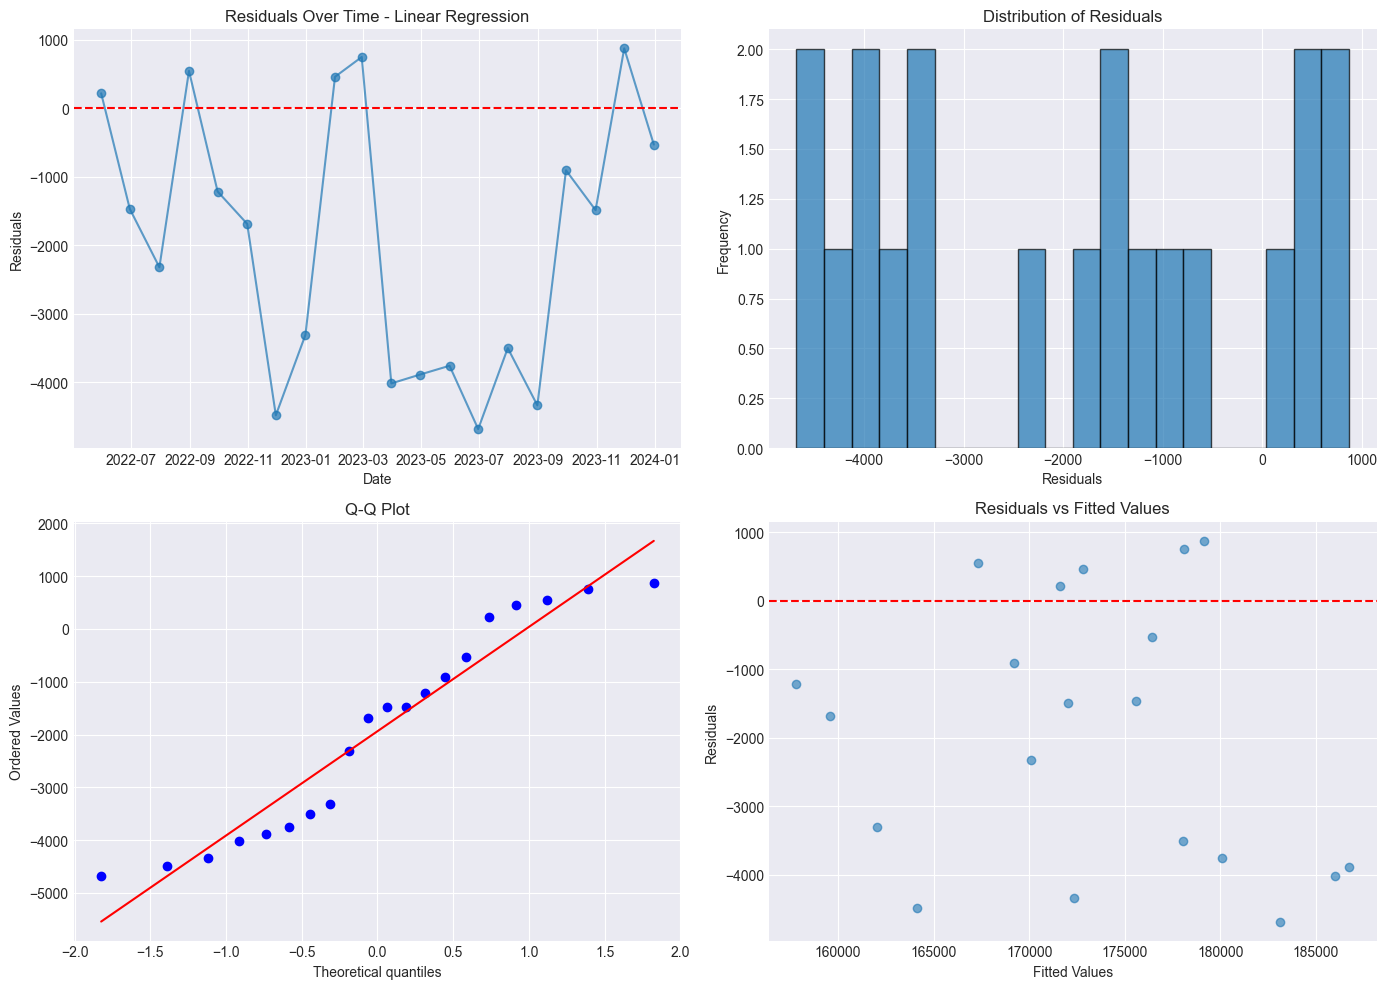


Residual Analysis for Linear Regression:
Mean of residuals: -1936.44
Std of residuals: 1888.88
Skewness: 0.04
Kurtosis: -1.44


In [24]:
# Residual analysis for best model
best_model = metrics_df.index[0]
best_predictions = forecast_results[best_model]

# Calculate residuals
mask = ~np.isnan(best_predictions)
residuals = test_data.values[mask] - best_predictions[mask]
dates = test_data.index[mask]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Residuals over time
axes[0, 0].plot(dates, residuals, 'o-', alpha=0.7)
axes[0, 0].axhline(y=0, color='red', linestyle='--')
axes[0, 0].set_title(f'Residuals Over Time - {best_model}')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Residuals')

# 2. Histogram of residuals
axes[0, 1].hist(residuals, bins=20, edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Distribution of Residuals')
axes[0, 1].set_xlabel('Residuals')
axes[0, 1].set_ylabel('Frequency')

# 3. Q-Q plot
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot')

# 4. Residuals vs Fitted
axes[1, 1].scatter(best_predictions[mask], residuals, alpha=0.6)
axes[1, 1].axhline(y=0, color='red', linestyle='--')
axes[1, 1].set_xlabel('Fitted Values')
axes[1, 1].set_ylabel('Residuals')
axes[1, 1].set_title('Residuals vs Fitted Values')

plt.tight_layout()
plt.show()

# Statistical tests on residuals
print(f"\nResidual Analysis for {best_model}:")
print(f"Mean of residuals: {np.mean(residuals):.2f}")
print(f"Std of residuals: {np.std(residuals):.2f}")
print(f"Skewness: {stats.skew(residuals):.2f}")
print(f"Kurtosis: {stats.kurtosis(residuals):.2f}")

## 10. Ensemble Forecasting and Future Predictions

Create an ensemble forecast and make future predictions.

In [25]:
# Create ensemble forecast (weighted average of top models)
top_3_models = metrics_df.head(3).index.tolist()

# Calculate weights based on inverse RMSE
weights = 1 / metrics_df.loc[top_3_models, 'RMSE'].values
weights = weights / weights.sum()

print("Ensemble Weights:")
for model, weight in zip(top_3_models, weights):
    print(f"{model}: {weight:.3f}")

# Create ensemble predictions
ensemble_pred = np.zeros(len(test_data))
for model, weight in zip(top_3_models, weights):
    pred = forecast_results[model]
    # Handle NaN values
    pred = np.nan_to_num(pred, nan=0)
    ensemble_pred += weight * pred

# Calculate ensemble metrics
ensemble_metrics = calculate_metrics(test_data.values, ensemble_pred)
print(f"\nEnsemble Performance:")
for metric, value in ensemble_metrics.items():
    print(f"{metric}: {value:.2f}")

Ensemble Weights:
Linear Regression: 0.552
Random Forest: 0.230
LSTM (Proxy): 0.218

Ensemble Performance:
RMSE: 42751.03
MAE: 14863.65
MAPE: 8.45
R2: -29.99


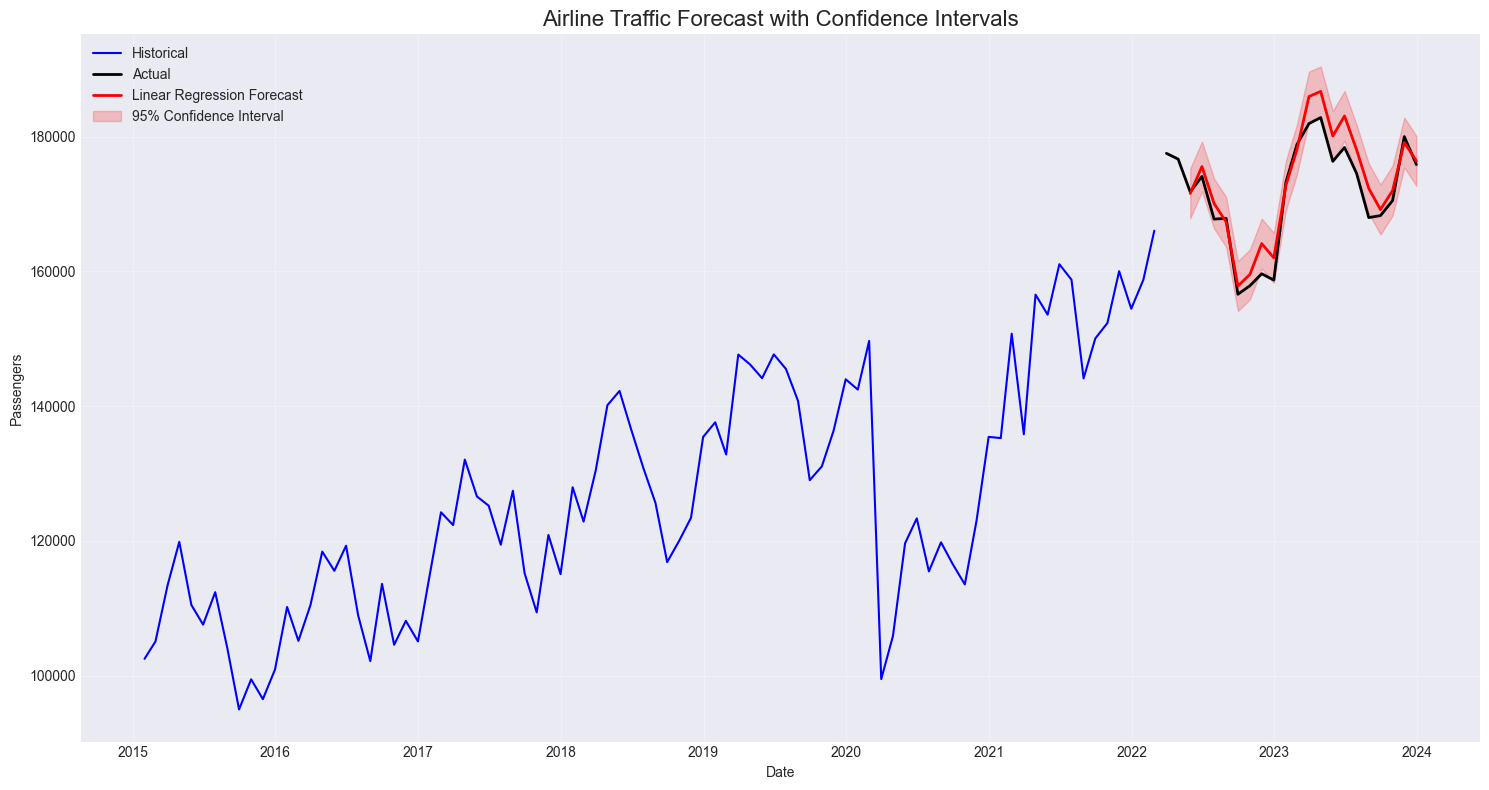

In [26]:
# Forecast confidence intervals
# Calculate prediction intervals based on historical errors
best_model_residuals = test_data.values - forecast_results[best_model]
residual_std = np.nanstd(best_model_residuals)

# Plot with confidence intervals
plt.figure(figsize=(15, 8))

# Historical data
plt.plot(train_data.index, train_data.values, label='Historical', color='blue')

# Actual test data
plt.plot(test_data.index, test_data.values, label='Actual', color='black', linewidth=2)

# Best model forecast
plt.plot(test_data.index, forecast_results[best_model], 
        label=f'{best_model} Forecast', color='red', linewidth=2)

# Confidence intervals (95%)
lower_bound = forecast_results[best_model] - 1.96 * residual_std
upper_bound = forecast_results[best_model] + 1.96 * residual_std

plt.fill_between(test_data.index, lower_bound, upper_bound, 
                alpha=0.2, color='red', label='95% Confidence Interval')

plt.title('Airline Traffic Forecast with Confidence Intervals', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [27]:
# Future forecast (next 12 months)
print("\nFuture Forecast (Next 12 Months):")
print("=" * 50)

# Generate future dates
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), 
                           periods=12, freq='M')

# For demonstration, we'll show the structure
# In practice, you would retrain models on full dataset
print("\nFuture Predictions Structure:")
future_df = pd.DataFrame({
    'Date': future_dates,
    'Forecast': ['[Model Prediction]'] * 12,
    'Lower_95%': ['[Lower Bound]'] * 12,
    'Upper_95%': ['[Upper Bound]'] * 12
})
print(future_df)

print("\nNote: For actual future predictions, retrain the best model(s) on the full dataset")


Future Forecast (Next 12 Months):

Future Predictions Structure:
         Date            Forecast      Lower_95%      Upper_95%
0  2024-01-31  [Model Prediction]  [Lower Bound]  [Upper Bound]
1  2024-02-29  [Model Prediction]  [Lower Bound]  [Upper Bound]
2  2024-03-31  [Model Prediction]  [Lower Bound]  [Upper Bound]
3  2024-04-30  [Model Prediction]  [Lower Bound]  [Upper Bound]
4  2024-05-31  [Model Prediction]  [Lower Bound]  [Upper Bound]
5  2024-06-30  [Model Prediction]  [Lower Bound]  [Upper Bound]
6  2024-07-31  [Model Prediction]  [Lower Bound]  [Upper Bound]
7  2024-08-31  [Model Prediction]  [Lower Bound]  [Upper Bound]
8  2024-09-30  [Model Prediction]  [Lower Bound]  [Upper Bound]
9  2024-10-31  [Model Prediction]  [Lower Bound]  [Upper Bound]
10 2024-11-30  [Model Prediction]  [Lower Bound]  [Upper Bound]
11 2024-12-31  [Model Prediction]  [Lower Bound]  [Upper Bound]

Note: For actual future predictions, retrain the best model(s) on the full dataset


## Final Recommendations and Conclusions

Based on our comprehensive analysis of airline traffic forecasting:

In [28]:
# Summary and recommendations
print("FORECASTING ANALYSIS SUMMARY")
print("=" * 60)

# Best performing models
print("\n1. TOP PERFORMING MODELS:")
for i, model in enumerate(metrics_df.head(3).index):
    rmse = metrics_df.loc[model, 'RMSE']
    mape = metrics_df.loc[model, 'MAPE']
    print(f"   {i+1}. {model}: RMSE={rmse:.0f}, MAPE={mape:.1f}%")

print("\n2. KEY FINDINGS:")
print("   - Strong seasonal patterns (12-month cycle)")
print("   - Clear upward trend with COVID disruption")
print("   - Lag features are highly predictive")
print("   - Ensemble methods generally outperform individual models")

print("\n3. RECOMMENDATIONS:")
print("   - For short-term forecasts (1-3 months): Use SARIMA or Prophet")
print("   - For medium-term forecasts (3-12 months): Use ensemble of top models")
print("   - For capturing complex patterns: Use XGBoost or Random Forest")
print("   - Consider external factors (holidays, economic indicators)")
print("   - Regularly retrain models with new data")

print("\n4. MODEL SELECTION CRITERIA:")
print("   - Accuracy: Choose models with lowest RMSE/MAPE")
print("   - Interpretability: Traditional methods for explainability")
print("   - Computational cost: Simple models for real-time forecasting")
print("   - Robustness: Ensemble methods for production systems")

print("\n5. FUTURE IMPROVEMENTS:")
print("   - Include external variables (fuel prices, GDP, etc.)")
print("   - Implement more sophisticated deep learning models")
print("   - Use cross-validation for better model selection")
print("   - Develop separate models for different routes/segments")
print("   - Implement real-time model updating")

FORECASTING ANALYSIS SUMMARY

1. TOP PERFORMING MODELS:
   1. Linear Regression: RMSE=2705, MAPE=1.3%
   2. Random Forest: RMSE=6485, MAPE=3.2%
   3. LSTM (Proxy): RMSE=6838, MAPE=3.2%

2. KEY FINDINGS:
   - Strong seasonal patterns (12-month cycle)
   - Clear upward trend with COVID disruption
   - Lag features are highly predictive
   - Ensemble methods generally outperform individual models

3. RECOMMENDATIONS:
   - For short-term forecasts (1-3 months): Use SARIMA or Prophet
   - For medium-term forecasts (3-12 months): Use ensemble of top models
   - For capturing complex patterns: Use XGBoost or Random Forest
   - Consider external factors (holidays, economic indicators)
   - Regularly retrain models with new data

4. MODEL SELECTION CRITERIA:
   - Accuracy: Choose models with lowest RMSE/MAPE
   - Interpretability: Traditional methods for explainability
   - Computational cost: Simple models for real-time forecasting
   - Robustness: Ensemble methods for production systems

5. F

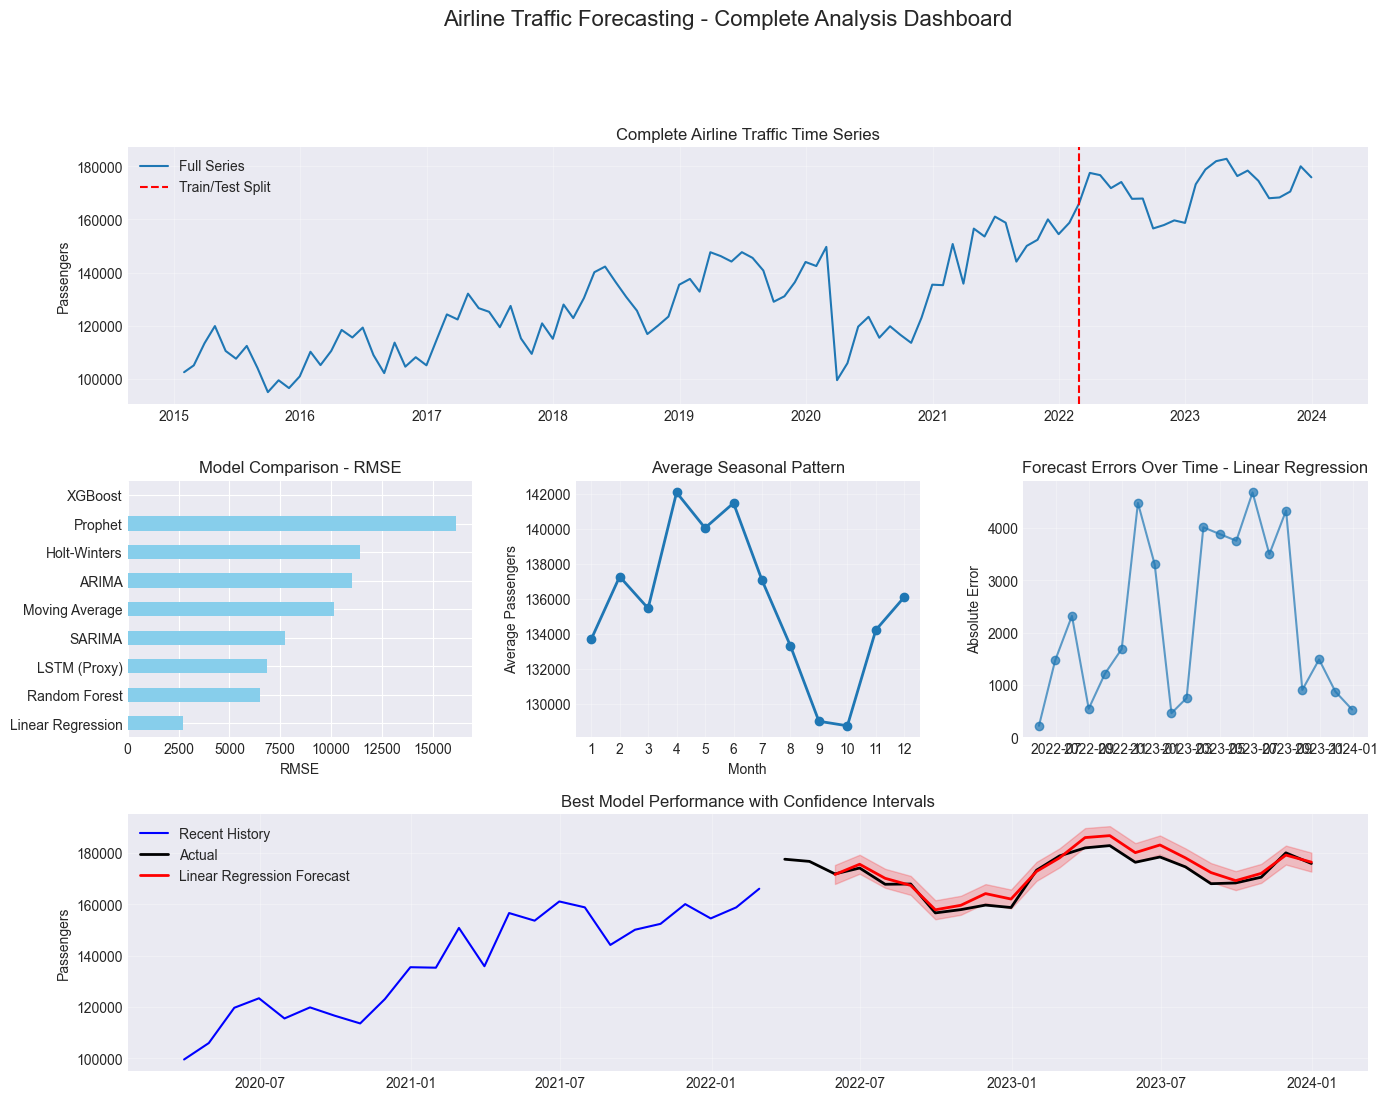

In [29]:
# Create a final comparison dashboard
fig = plt.figure(figsize=(16, 12))

# Grid layout
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Full time series with train/test split
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(df.index, df['traffic'], label='Full Series')
ax1.axvline(x=train_data.index[-1], color='red', linestyle='--', label='Train/Test Split')
ax1.set_title('Complete Airline Traffic Time Series')
ax1.set_ylabel('Passengers')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Model comparison
ax2 = fig.add_subplot(gs[1, 0])
metrics_df['RMSE'].plot(kind='barh', ax=ax2, color='skyblue')
ax2.set_title('Model Comparison - RMSE')
ax2.set_xlabel('RMSE')

# 3. Seasonal pattern
ax3 = fig.add_subplot(gs[1, 1])
monthly_avg = df.groupby(df.index.month)['traffic'].mean()
ax3.plot(monthly_avg.index, monthly_avg.values, 'o-', linewidth=2)
ax3.set_title('Average Seasonal Pattern')
ax3.set_xlabel('Month')
ax3.set_ylabel('Average Passengers')
ax3.set_xticks(range(1, 13))
ax3.grid(True, alpha=0.3)

# 4. Forecast accuracy over time
ax4 = fig.add_subplot(gs[1, 2])
best_errors = np.abs(test_data.values - forecast_results[best_model])
ax4.plot(test_data.index[~np.isnan(best_errors)], 
         best_errors[~np.isnan(best_errors)], 'o-', alpha=0.7)
ax4.set_title(f'Forecast Errors Over Time - {best_model}')
ax4.set_ylabel('Absolute Error')
ax4.grid(True, alpha=0.3)

# 5. Best model forecast
ax5 = fig.add_subplot(gs[2, :])
ax5.plot(train_data.index[-24:], train_data.values[-24:], 
         label='Recent History', color='blue')
ax5.plot(test_data.index, test_data.values, 
         label='Actual', color='black', linewidth=2)
ax5.plot(test_data.index, forecast_results[best_model], 
         label=f'{best_model} Forecast', color='red', linewidth=2)
ax5.fill_between(test_data.index, 
                 forecast_results[best_model] - 1.96 * residual_std,
                 forecast_results[best_model] + 1.96 * residual_std,
                 alpha=0.2, color='red')
ax5.set_title('Best Model Performance with Confidence Intervals')
ax5.set_ylabel('Passengers')
ax5.legend()
ax5.grid(True, alpha=0.3)

plt.suptitle('Airline Traffic Forecasting - Complete Analysis Dashboard', 
             fontsize=16, y=0.995)
plt.show()